__оценка схожести изображений с помощью сиамской нейросети__

Евгений Борисов borisov.e@solarl.ru

http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf    

In [1]:
DATASET_FOLDER = 'data/fashion-mnist'

## библиотеки

In [2]:
from os.path import join as pjoin
from os import listdir
from itertools import combinations

import numpy as np
import numpy.random as rng

from matplotlib import pyplot as plt

## загружаем учебный набор

In [3]:
# !ls data/pascal/my
!ls data/fashion-mnist

t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte.gz
t10k-labels-idx1-ubyte.gz  train-labels-idx1-ubyte.gz


In [4]:
# from tensorflow.keras.datasets import fashion_mnist
# _, (X,_ ) = fashion_mnist.load_data()

In [5]:
# http://yann.lecun.com/exdb/mnist/

import gzip
import idx2numpy

In [6]:
with gzip.open( pjoin(DATASET_FOLDER,'train-images-idx3-ubyte.gz'),'rb') as f:
    x_train = np.expand_dims( idx2numpy.convert_from_string(f.read()), axis=-1 )
    
with gzip.open( pjoin(DATASET_FOLDER,'train-labels-idx1-ubyte.gz'),'rb') as f:
    y_train = idx2numpy.convert_from_string(f.read())
    
x_train = (x_train-127.5)/127.5

x_train.min(), x_train.max(), x_train.shape, y_train.shape

(-1.0, 1.0, (60000, 28, 28, 1), (60000,))

----

In [7]:
n_samples, im_w, im_h, im_c = x_train.shape
n_samples, im_w, im_h, im_c

(60000, 28, 28, 1)

In [8]:
def ar2im(x): return ((x-x.min())/(x.max()-x.min())*255.).astype(np.uint8)

In [9]:
def plot_samples(X,n_show=15,columns=9,cmap='gray_r'):
    ii = rng.permutation(X.shape[0])[:n_show]
    plt.figure(figsize=(2*columns,2*(n_show //columns+1)))
    for n,xi in enumerate(X[ii]):
        img = ar2im(xi)
        plt.subplot( n_show//columns+1, columns, n+1)
        plt.axis(False)
        plt.imshow(img,cmap=cmap)

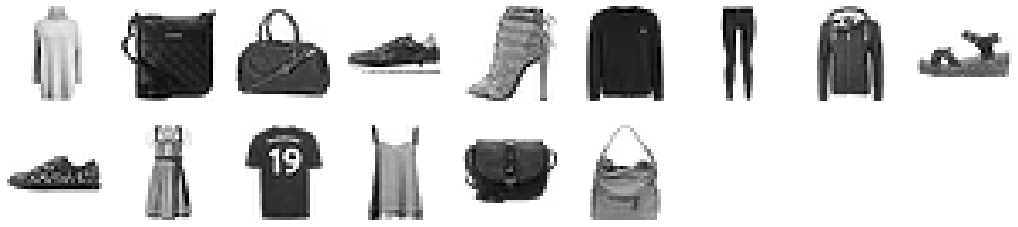

In [10]:
plot_samples(x_train)

In [11]:
x_train.shape

(60000, 28, 28, 1)

## строим учебный датасет

In [12]:
# собираем датасет

In [13]:
# позитивные примеры - пары одного класса
def sample_pos_class(x,y,c):
    xc = x[y==c] # выбираем примеры класса с
    n = xc.shape[0] # количество примеров класса с
    i = rng.permutation(n) # индексы примеров в случайном порядке
    return xc[i,:],xc 

def sample_pos(x,y):
    x_left,x_right = [],[]
    for c in set(y):
        xl,xr = sample_pos_class(x,y,c)
        x_left.append(xl)
        x_right.append(xr)
    return np.vstack(x_left),np.vstack(x_right)

In [14]:
# негативные примеры - пары разных классов

# размножить примеры класса
def reproduce_samples(x,dn):
    n = x.shape[0] 
    i = rng.permutation(n)[:dn]
    return np.vstack([x,x[i,:]])

def sample_neg_class(x,y,c0,c1):
    assert c0!=c1
    xc0 = x[y==c0] # выбираем примеры класса с0
    xc1 = x[y==c1] # выбираем примеры класса с1
    
    n0 = xc0.shape[0] # количество примеров класса с0
    n1 = xc1.shape[0] # количество примеров класса с1
    
    # выравниваем количества примеров в классах
    if n0>n1: # в классе с1 меньше примеров
        xc1 = reproduce_samples(xc1,n0-n1)
        n1=xc1.shape[0]
        
    if n0<n1: # в классе с0 меньше примеров
        xc0 = reproduce_samples(xc0,n1-n0)
        n0=xc0.shape[0]

    # индексы примеров в случайном порядке
    i0 = rng.permutation(n0) 
    i1 = rng.permutation(n1) 

    return xc0[i0,:],xc1[i1,:] 
    
# xl,xr = sample_neg_class(x_train,y_train,2,3)


def sample_neg(x,y,p=-1):
    cc = set(y) # список классов
    
    # все комбинации разных классов
    cc = list(combinations(cc,2))
    
    
    # ограничиваем количество пар
    if p>0: cc = rng.permutation(cc)[:p]

    x_left,x_right = [],[]
    for c0,c1 in cc:
        xl,xr = sample_neg_class(x,y,c0,c1)
        x_left.append(xl)
        x_right.append(xr) 
        
    return np.vstack(x_left),np.vstack(x_right)    

In [15]:
# картинки похожие, позитивные примеры
x_left_p, x_right_p = sample_pos(x_train,y_train)
target_p = np.ones((x_left_p.shape[0],1),dtype=np.float32)

x_left_p.shape, x_right_p.shape, target_p.shape  

((60000, 28, 28, 1), (60000, 28, 28, 1), (60000, 1))

In [16]:
# картинки не похожие негативные примеры
x_left_n,x_right_n = sample_neg(x_train,y_train)
target_n = np.zeros((x_left_n.shape[0],1),dtype=np.float32)

x_left_n.shape, x_right_n.shape, target_n.shape     

((270000, 28, 28, 1), (270000, 28, 28, 1), (270000, 1))

In [17]:
x_left_train  = np.vstack([x_left_n,  x_left_p])
x_right_train = np.vstack([x_right_n, x_right_p])
target_train  = np.vstack([target_n, target_p])

x_left_train.shape, x_right_train.shape, target_train.shape

((330000, 28, 28, 1), (330000, 28, 28, 1), (330000, 1))

In [18]:
def shuffle_dataset(x_left, x_right, target):
    ii = rng.permutation(x_left.shape[0])
    return x_left[ii,:],x_right[ii,:],target[ii,:]

## строим модель

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

from tensorflow.keras.layers import Lambda

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

from tensorflow_addons.losses import contrastive_loss

from tensorflow.keras.callbacks import TensorBoard

from tensorflow.keras.utils import plot_model


In [20]:
def get_siamese_model(input_shape,regularizer_rate=2e-4):
    left_input, right_input = Input(input_shape), Input(input_shape)
        
    model = Sequential()
    model.add(Conv2D(64,(3,3),activation='relu',input_shape=input_shape,kernel_regularizer=l2(regularizer_rate)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))    
    model.add(Conv2D(128,(3,3),activation='relu',kernel_regularizer=l2(regularizer_rate)))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    model.add(Conv2D(256, (3,3),activation='relu', kernel_regularizer=l2(regularizer_rate)))
    model.add(Flatten())
    model.add(Dense(512, activation='sigmoid',kernel_regularizer=l2(regularizer_rate), )) 
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda t : K.abs(t[0]-t[1]))
    
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    return siamese_net

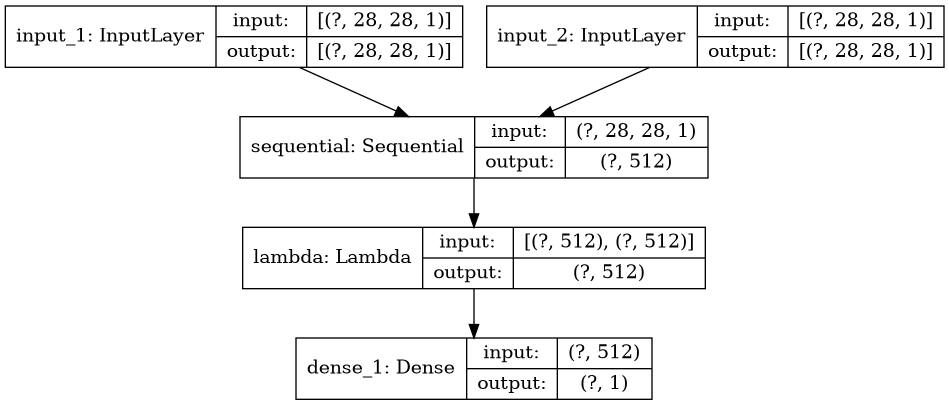

In [21]:
model = get_siamese_model((im_w,im_h,im_c))
# model.summary()
plot_model(model, show_layer_names=True, show_shapes=True )

## обучаем модель

In [22]:
!rm -r ./tb_log
!mkdir ./tb_log

# tensorboard --logdir='./tb_log'

rm: невозможно удалить './tb_log': Нет такого файла или каталога


In [23]:
learning_rate = 1e-5
optimizer=Adam(lr=learning_rate)
model.compile(loss=contrastive_loss,optimizer=optimizer)

In [24]:
x_left_train.shape, x_right_train.shape, target_train.shape

((330000, 28, 28, 1), (330000, 28, 28, 1), (330000, 1))

In [25]:
x_left_train,x_right_train,target_train = shuffle_dataset(x_left_train,x_right_train,target_train)

In [26]:
%%time

model.fit( [x_left_train, x_right_train], target_train,
           epochs=5,
           batch_size=512,
           callbacks=[
                      # EarlyStopping(monitor='acc',baseline=.98, patience=2,), # restore_best_weights=True),
                      TensorBoard(log_dir='./tb_log'),
                    ],
           #validation_split=.3,
           #validation_data=(x_val, y_val)
         )


Epoch 1/5
  1/645 [..............................] - ETA: 3s - loss: 0.4682WARNING:tensorflow:From /usr/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
645/645 [==============================] - 34s 52ms/step - loss: 0.3452
Epoch 2/5
645/645 [==============================] - 33s 52ms/step - loss: 0.2614
Epoch 3/5
645/645 [==============================] - 33s 52ms/step - loss: 0.2214
Epoch 4/5
645/645 [==============================] - 33s 52ms/step - loss: 0.1914
Epoch 5/5
645/645 [==============================] - 34s 52ms/step - loss: 0.1692
CPU times: user 1min 58s, sys: 2.19 s, total: 2min 1s
Wall time: 2min 51s


## тестовый датасет

In [27]:
with gzip.open( pjoin(DATASET_FOLDER,'t10k-images-idx3-ubyte.gz'),'rb') as f:
    x_test = np.expand_dims( idx2numpy.convert_from_string(f.read()), axis=-1 )
    
with gzip.open( pjoin(DATASET_FOLDER,'t10k-labels-idx1-ubyte.gz'),'rb') as f:
    y_test = idx2numpy.convert_from_string(f.read())
    
x_test = (x_test-127.5)/127.5

x_test.min(), x_test.max(), x_test.shape, y_test.shape

(-1.0, 1.0, (10000, 28, 28, 1), (10000,))

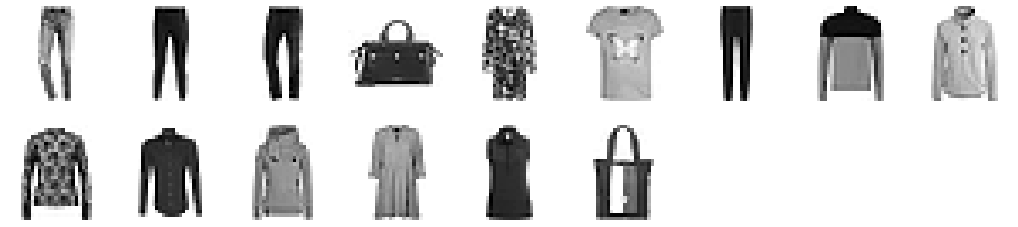

In [28]:
plot_samples(x_test)

In [30]:
x_left_p, x_right_p = sample_pos(x_test,y_test)
# target_p = np.ones((x_left_p.shape[0],1),dtype=np.float32)

x_left_n,x_right_n = sample_neg(x_test,y_test)
# target_n = np.zeros((x_left_n.shape[0],1),dtype=np.float32)

x_left_test  = np.vstack([x_left_n,  x_left_p])
x_right_test = np.vstack([x_right_n, x_right_p])
# target_test  = np.vstack([target_n, target_p])

x_left_test.shape, x_right_test.shape, # target_test.shape

((55000, 28, 28, 1), (55000, 28, 28, 1))

---

In [31]:
p = model.predict([x_left_test,x_right_test])

In [32]:
p.shape

(55000, 1)

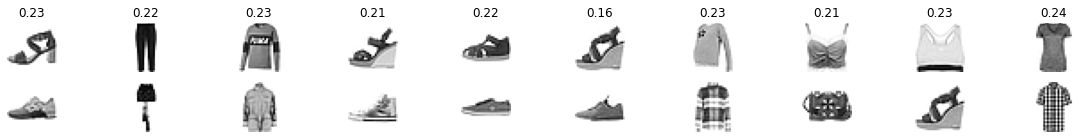

In [42]:
n_show = 10
cmap='gray_r'

ii = np.where(p.flatten()<.25)[0]
ii = rng.permutation(ii[:n_show])

fig,ax = plt.subplots(2,n_show,figsize=(n_show*2,2))
for n,i in enumerate(ii):
    imgL = ar2im(x_left_test[i,:])
    imgR = ar2im(x_right_test[i,:])
    
    ax[0][n].axis(False)
    ax[0][n].imshow(imgL,cmap=cmap)
    ax[0][n].set_title('%.2f'%p[i])
    
    ax[1][n].axis(False)
    ax[1][n].imshow(imgR,cmap=cmap)
    

# p[ii]    

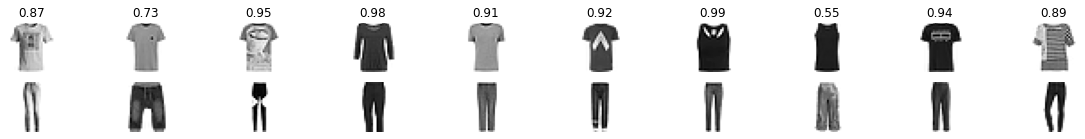

In [43]:
n_show = 10
cmap='gray_r'

ii = np.where(p.flatten()>.2)[0]
ii = rng.permutation(ii[:n_show])

fig,ax = plt.subplots(2,n_show,figsize=(n_show*2,2))
for n,i in enumerate(ii):
    imgL = ar2im(x_left_test[i,:])
    imgR = ar2im(x_right_test[i,:])
    
    ax[0][n].axis(False)
    ax[0][n].imshow(imgL,cmap=cmap)
    ax[0][n].set_title('%.2f'%p[i])
    
    ax[1][n].axis(False)
    ax[1][n].imshow(imgR,cmap=cmap)
    

---

In [ ]:
# X = idx2numpy.convert_from_file(  pjoin(DATASET_FOLDER,'t10k-images-idx3-ubyte_'))

In [ ]:
# TRAINING SET IMAGE FILE (train-images-idx3-ubyte):
# [offset] [type]          [value]          [description]
# 0000     32 bit integer  0x00000803(2051) magic number
# 0004     32 bit integer  60000            number of images
# 0008     32 bit integer  28               number of rows
# 0012     32 bit integer  28               number of columns
# 0016     unsigned byte   ??               pixel
# 0017     unsigned byte   ??               pixel
# ........
# xxxx     unsigned byte   ??               pixel

In [ ]:
# np.frombuffer(buf,dtype=np.int32)

# import gzip
# f = gzip.open('train-images-idx3-ubyte.gz','r')

# image_size = 28
# num_images = 5

# import numpy as np
# f.read(16)
# buf = f.read(image_size * image_size * num_images)
# data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
# data = data.reshape(num_images, image_size, image_size, 1)
# Print images:

# import matplotlib.pyplot as plt
# image = np.asarray(data[2]).squeeze()
# plt.imshow(image)
# plt.show()
# enter image description here

# Print first 50 labels:

# f = gzip.open('train-labels-idx1-ubyte.gz','r')
# f.read(8)
# for i in range(0,50):   
#     buf = f.read(1)
#     labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
#     print(labels)